# Bent waveguides (layout and simulation)

Step by step process:
1. Draw a bent waveguide and save it in a .gds file.
2. Load the bent waveguide using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute loss and reflection of the bend.

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Debug info
print("Meep version:", mp.__version__)

Meep version: 1.17


In [2]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)

## Simulation Parameters

In [3]:
ring_radius = 10 # um
ring_width = 0.5 # um
pml_width = 1.0 # um
straight_wg_length = pml_width + 0.2 # um

# Simulation resolution
res = 128        # pixels/μm

## Step 1. Drawing a bent waveguide and saving into a temporary .gds file

In [4]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0

# Source port
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
# Input port (immediately at the start of the bend)
layout_path(TOP, MEEP_PORT1,   [-port_size/2*ey, port_size/2*ey], 0)
# Output port (immediately at the end of the bend)
layout_path(TOP, MEEP_PORT2,   [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                               -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - straight_wg_length * (ex + ey), # Bottom left point 
            1.0*ring_radius*ex + (straight_wg_length + port_size / 2) * (ex + ey),  # Top right point
           ex)

# Write to file
layout.write(filename)
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmpwhiljd79.gds.
-rw-rw-r-- 1 josh josh 2.4K Feb 25 18:12 /tmp/tmpwhiljd79.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [5]:
gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0.1
si_zmin = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(pml_width)],
                    sources=sources,
                    geometry=si_layer,
                    geometry_center=cell.center)

# Delete file created in previous cell

import os 
temp_file.close()
os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [6]:
sim.reset_meep()

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, df, 25, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, df, 25, mp.ModeRegion(volume=p2))

# Let's store the frequencies that were generated by this mode monitor
mode1_freqs = np.array(mp.get_eigenmode_freqs(mode1))
mode2_freqs = np.array(mp.get_eigenmode_freqs(mode2))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00139999 s
Working in 2D dimensions.
Computational cell is 13.3984 x 13.3984 x 0 with resolution 128
     prism, center = (6.32432,-3.67568,0.05)
          height 0.1, axis (0,0,1), sidewall angle: 0 radians, 240 vertices:
          (9.75,-10,0)
          (9.749,-9.88,0)
          (9.747,-9.761,0)
          (9.743,-9.641,0)
          (9.738,-9.522,0)
          (9.732,-9.402,0)
          (9.724,-9.283,0)
          (9.714,-9.163,0)
          (9.703,-9.044,0)
          (9.691,-8.925,0)
          (9.677,-8.806,0)
          (9.661,-8.688,0)
          (9.644,-8.569,0)
          (9.626,-8.451,0)
          (9.606,-8.333,0)
          (9.585,-8.215,0)
          (9.563,-8.098,0)
          (9.539,-7.981,0)
          (9.513,-7.864,0)
          (9.486,-7.747,0)
          (9.458,-7.631,0)
          (9.428,-7.515,0)
          (9.397,-7.4,0)
          (9.364,-7.284,0)
          (9.33,-7.17,0)
          (9.295,-7.055,0)
          (9

grid initialization is 61.5778% done, 2.52093 s remaining
grid initialization is 65.106% done, 2.1633 s remaining
grid initialization is 68.6341% done, 1.84789 s remaining
grid initialization is 72.1622% done, 1.55724 s remaining
grid initialization is 75.6904% done, 1.29792 s remaining
grid initialization is 79.2185% done, 1.05933 s remaining
grid initialization is 82.6996% done, 0.836986 s remaining
grid initialization is 86.2278% done, 0.64613 s remaining
grid initialization is 89.7559% done, 0.462446 s remaining
grid initialization is 5.22161% done, 72.6372 s remaining
grid initialization is 8.74975% done, 41.9702 s remaining
grid initialization is 12.2779% done, 28.7586 s remaining
grid initialization is 15.806% done, 21.4571 s remaining
grid initialization is 19.3342% done, 16.8074 s remaining
grid initialization is 22.8623% done, 13.5989 s remaining
grid initialization is 26.3905% done, 11.3108 s remaining
grid initialization is 29.9186% done, 9.45018 s remaining
grid initializa

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

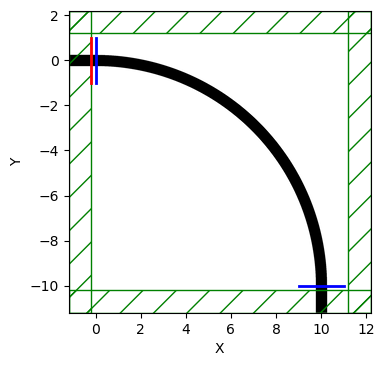

In [7]:
# If there is a warning that reads "The specified user volume
# is larger than the simulation domain and has been truncated",
# It has to do with some numerical errors between python and meep.
# Ignore.

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

More detailed meep documentation available [here](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend).

In [8]:
# Set to true to compute animation (may take a lot of memory)
compute_animation = True

In [9]:
# Setup and run the simulation

# The following line defines a stopping condition depending on the square
# of the amplitude of the Ez field at the port 2.
print(f"Stop condition: decay to 0.1% of peak value in the last {2.0/df:.1f} time units.")
stop_condition = mp.stop_when_fields_decayed(2.0/df,mp.Ez,p2.center,1e-3)
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=stop_condition)
    plt.close()
else:
    sim.run(until_after_sources=stop_condition)

Stop condition: decay to 0.1% of peak value in the last 15.5 time units.
on time step 131 (time=0.511719), 0.0307258 s/step
on time step 256 (time=1), 0.0666501 s/step
on time step 399 (time=1.55859), 0.0280737 s/step
on time step 541 (time=2.11328), 0.0282697 s/step
on time step 685 (time=2.67578), 0.0278293 s/step
on time step 821 (time=3.20703), 0.0295087 s/step
on time step 953 (time=3.72266), 0.030358 s/step
on time step 1090 (time=4.25781), 0.0293898 s/step
on time step 1231 (time=4.80859), 0.0283797 s/step
on time step 1371 (time=5.35547), 0.0286935 s/step
on time step 1514 (time=5.91406), 0.0279985 s/step
on time step 1652 (time=6.45312), 0.0291375 s/step
on time step 1792 (time=7), 0.0292151 s/step
on time step 1934 (time=7.55469), 0.0281945 s/step
on time step 2072 (time=8.09375), 0.0290662 s/step
on time step 2215 (time=8.65234), 0.0280031 s/step
on time step 2353 (time=9.19141), 0.0290236 s/step
on time step 2494 (time=9.74219), 0.028409 s/step
on time step 2631 (time=10.27

on time step 21676 (time=84.6719), 0.0278972 s/step
on time step 21816 (time=85.2188), 0.0286027 s/step
on time step 21961 (time=85.7852), 0.02761 s/step
on time step 22101 (time=86.332), 0.028578 s/step
on time step 22246 (time=86.8984), 0.0277091 s/step
on time step 22388 (time=87.4531), 0.0282776 s/step
on time step 22528 (time=88), 0.0285991 s/step
on time step 22673 (time=88.5664), 0.0276201 s/step
on time step 22814 (time=89.1172), 0.0285498 s/step
on time step 22956 (time=89.6719), 0.0282986 s/step
on time step 23096 (time=90.2188), 0.0286246 s/step
on time step 23240 (time=90.7812), 0.0278115 s/step
on time step 23380 (time=91.3281), 0.0285803 s/step
on time step 23525 (time=91.8945), 0.0277339 s/step
on time step 23664 (time=92.4375), 0.0288441 s/step
on time step 23808 (time=93), 0.0283858 s/step
field decay(t = 93.0234375): 3.2458191675074395 / 3.2458191675074395 = 1.0
on time step 23950 (time=93.5547), 0.0282045 s/step
on time step 24084 (time=94.0781), 0.0300263 s/step
on 

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through port2 in its entirety? Given the automatic stop condition, this should be the case.

In [10]:
from IPython.display import Video, display
if compute_animation:
    # Save video as gif
    animate.to_mp4(10, 'media/bend.mp4')
    # Play video
    display(animate.to_jshtml(10))
else:
    # Load pre-computed video from .gif
    display(Video('media/bend.mp4'))

Generating MP4...


## Step 5. Compute loss and reflection of the bend

In [11]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction
eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY)
eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)

# First, we need to figure out which direction the "dominant planewave" k-vector is
# We can pick the first frequency (0) for that, assuming that for all simulated frequencies,
# The dominant k-vector will point in the same direction.
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the +x direction, so if k1.x is positive, select 0, otherwise 1
idx = (k1.x < 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,:,idx]
p1_reflected_coeff = eig_mode1.alpha[0,:,1-idx]

# For port 2, we are interestred in the -y direction
idx = (k2.y > 0) * 1
p2_thru_coeff = eig_mode2.alpha[0,:,idx]
p2_reflected_coeff = eig_mode2.alpha[0,:,1-idx]

# transmittance
p2_trans = abs(p2_thru_coeff/p1_thru_coeff)**2
p2_reflected = abs(p1_reflected_coeff/p1_thru_coeff)**2

print("----------------------------------")
print(f"Parameters: radius={ring_radius:.1f}")
print(f"Frequencies: {mode1_freqs}")
print(f"Transmitted fraction: {p2_trans}")
print(f"Reflected fraction: {p2_reflected}")

MPB solved for frequency_1(2.01141,0,0) = 0.618857 after 32 iters
MPB solved for frequency_1(1.87474,0,0) = 0.580676 after 10 iters
MPB solved for frequency_1(1.87463,0,0) = 0.580645 after 4 iters
MPB solved for frequency_1(1.87463,0,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.874630,-0.000000,0.000000)
MPB solved for frequency_1(1.89389,0,0) = 0.586022 after 31 iters
MPB solved for frequency_1(1.89389,0,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.893889,-0.000000,0.000000)
MPB solved for frequency_1(1.91314,0,0) = 0.591398 after 31 iters
MPB solved for frequency_1(1.91314,0,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (1.913143,-0.000000,0.000000)
MPB solved for frequency_1(1.93239,0,0) = 0.596775 after 32 iters
MPB solved for frequency_1(1.93239,0,0) = 0.596774 after 1 iters
Dominant planewave for band 1: (1.932393,-0.000000,0.000000)
MPB solved for frequency_1(1.95164,0,0) = 0.602151 after 32 iters
MPB solved for frequency_1(1.95164,

Dominant planewave for band 1: (0.000000,2.182247,0.000000)
MPB solved for frequency_1(0,2.20144,0) = 0.672044 after 35 iters
MPB solved for frequency_1(0,2.20144,0) = 0.672043 after 1 iters
Dominant planewave for band 1: (0.000000,2.201436,0.000000)
MPB solved for frequency_1(0,2.22062,0) = 0.67742 after 35 iters
MPB solved for frequency_1(0,2.22062,0) = 0.677419 after 1 iters
Dominant planewave for band 1: (0.000000,2.220622,0.000000)
MPB solved for frequency_1(0,2.23981,0) = 0.682796 after 35 iters
MPB solved for frequency_1(0,2.2398,0) = 0.682796 after 1 iters
Dominant planewave for band 1: (0.000000,2.239803,0.000000)
MPB solved for frequency_1(0,2.25898,0) = 0.688173 after 36 iters
MPB solved for frequency_1(0,2.25898,0) = 0.688172 after 1 iters
Dominant planewave for band 1: (0.000000,2.258980,0.000000)
MPB solved for frequency_1(0,2.27816,0) = 0.693549 after 36 iters
MPB solved for frequency_1(0,2.27815,0) = 0.693548 after 1 iters
Dominant planewave for band 1: (0.000000,2.2781

# Milestones

Goal: Compute the transmission profile for bend radii between 1.5um and 10um. 

- Q: Is the reflection significant for any radius? What explain the loss?
- Q: What is the formula total size of the simulation region? How many pixels are there?
- Q: If each pixel can host 3-dimensional E-field and H-field vectors with 64bit complex float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
- Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
- Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.

In [12]:
p2_trans_mag = np.abs(p2_thru_coeff/p1_thru_coeff)
p2_trans_phase = np.unwrap(np.angle(p2_thru_coeff/p1_thru_coeff))
p1_refl_mag = np.abs(p1_reflected_coeff/p1_thru_coeff)
p1_refl_phase = np.unwrap(np.angle(p1_reflected_coeff/p1_thru_coeff))

In [15]:
#Write to csv file
import csv
with open('sparams.csv', mode='w') as sparams_file:
    sparam_writer = csv.writer(sparams_file, delimiter=',')
    for i in range(len(mode1_freqs)):
        sparam_writer.writerow([mode1_freqs[i],
                                p1_thru_coeff[i],
                                p2_thru_coeff[i],
                                p1_reflected_coeff[i],
                                p2_reflected_coeff[i]])

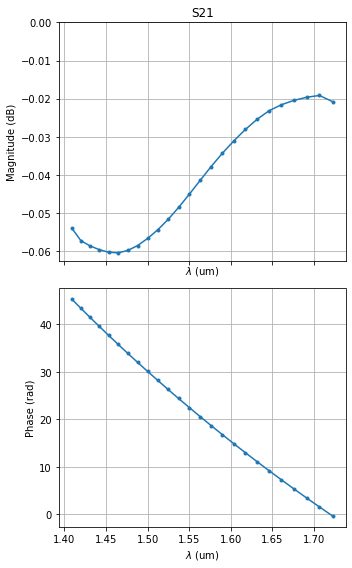

In [14]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(p2_trans_mag), '.-')
ax1.set_title("S21")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, p2_trans_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

In [ ]:
# Plot S11
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(p1_refl_mag), '.-')
ax1.set_title("S11")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, p1_refl_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()